In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torchinfo import summary

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

## MNIST

#### GPU Acceleration

In [4]:
# Enable GPU device if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
x = torch.randn(2, 2)
model = torch.nn.Linear(1, 1)
w1, b1 = list(model.parameters())[:2]
print(f'x: {x.device}, Layer1: {w1.device}, {b1.device}')

x = x.to(device)
model = model.to(device)
print(f'x: {x.device}, Layer1: {w1.device}, {b1.device}')

x: cpu, Layer1: cpu, cpu
x: cuda:0, Layer1: cuda:0, cuda:0


#### Pre-processing by transforms

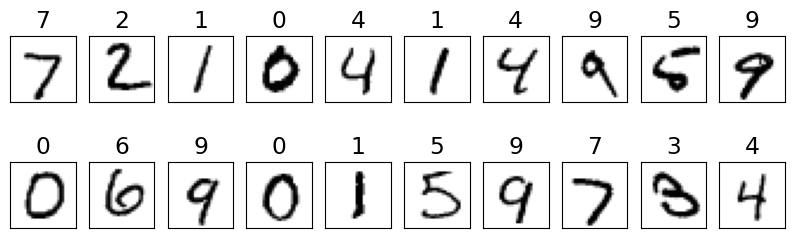

In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),                   # numpy -> torch.Tensor
    transforms.Normalize(0.5,  0.5),         # Normalize
    transforms.Lambda(lambda x: x.view(-1))  # Tensor(28, 28) -> Tensor(784)
])

def decode_to_image(x):
    x = x.view(28, 28)
    x = x * 0.5 + 0.5
    return transforms.ToPILImage()(x)

# Download datasets and transform them.
data_root = '/content/drive/MyDrive/datasets'

train_dataset = datasets.MNIST(
    root=data_root,  train=True, download=True,
    transform = transform)

test_dataset = datasets.MNIST(
    root=data_root,  train=False, download=True,
    transform = transform)

# Visualize images.
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    input, label = test_dataset[i]
    image = decode_to_image(input)

    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Mini-Batch Training
| Batch Size | Time | Accuracy | Remarks |
| --- | --- | --- | --- |
| Large | Short | Low  | Stable learning due to noise robustness<br>Risk of local minimum.|
| Small | Long  | High | Learning stagnation due to noise sensitivity |

In [7]:
from torch.utils.data import DataLoader

batch_size = 500
train_loader = DataLoader(
    train_dataset, batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    test_dataset,  batch_size = batch_size,
    shuffle = False)

print(f'train total {len(train_dataset)} = batch size {batch_size} * batch num {len(train_loader)}')
print(f'test  total {len(test_dataset)} = batch size {batch_size} * batch num {len(test_loader)}')

train total 60000 = batch size 500 * batch num 120
test  total 10000 = batch size 500 * batch num 20


## Train and Test

In [8]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [9]:
def train(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train'):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def test(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test'):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def visualize(train_history, test_history, figsize=(12,5)):
    train_history = np.array(train_history)
    test_history = np.array(test_history)

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.set_ylabel('Loss')
    ax.plot(train_history[:, 0], train_history[:, 1], label='train')
    ax.plot(test_history[:, 0], test_history[:, 1], label='test')
    ax.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_ylabel('Accuracy')
    ax.plot(train_history[:, 0], train_history[:, 2], label='train')
    ax.plot(test_history[:, 0], test_history[:, 2], label='test')
    ax.legend()

    plt.show()


def train_and_test(num_epochs, model, criterion, optimizer, train_loader, test_loader, device):
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc = test(model, criterion, optimizer, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    visualize(train_history, test_history)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            100,480
├─Linear: 1-2                            1,290
├─ReLU: 1-3                              --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0

Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.79067 acc: 0.59115 test_loss: 1.27891, test_acc: 0.77380


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.00090 acc: 0.80423 test_loss: 0.77473, test_acc: 0.83690


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.69054 acc: 0.84423 test_loss: 0.59170, test_acc: 0.86450


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.56443 acc: 0.86123 test_loss: 0.50529, test_acc: 0.87550


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.49753 acc: 0.87150 test_loss: 0.45417, test_acc: 0.88390


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.45621 acc: 0.87827 test_loss: 0.42111, test_acc: 0.88850


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.42787 acc: 0.88448 test_loss: 0.39679, test_acc: 0.89270


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.40724 acc: 0.88797 test_loss: 0.37991, test_acc: 0.89520


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.39110 acc: 0.89215 test_loss: 0.36659, test_acc: 0.89790


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.37848 acc: 0.89433 test_loss: 0.35615, test_acc: 0.90000


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.36826 acc: 0.89612 test_loss: 0.34594, test_acc: 0.90230


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.35933 acc: 0.89858 test_loss: 0.33812, test_acc: 0.90290


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.35179 acc: 0.90027 test_loss: 0.33188, test_acc: 0.90610


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.34506 acc: 0.90173 test_loss: 0.32633, test_acc: 0.90620


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.33914 acc: 0.90345 test_loss: 0.32142, test_acc: 0.90960


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.33407 acc: 0.90438 test_loss: 0.31725, test_acc: 0.90920


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.32909 acc: 0.90545 test_loss: 0.31266, test_acc: 0.91040


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.32474 acc: 0.90728 test_loss: 0.30898, test_acc: 0.91030


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.32070 acc: 0.90810 test_loss: 0.30572, test_acc: 0.91130


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.31688 acc: 0.90885 test_loss: 0.30219, test_acc: 0.91380


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.31339 acc: 0.91082 test_loss: 0.29903, test_acc: 0.91330


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.31004 acc: 0.91085 test_loss: 0.29609, test_acc: 0.91440


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.30707 acc: 0.91197 test_loss: 0.29332, test_acc: 0.91420


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.30394 acc: 0.91285 test_loss: 0.29080, test_acc: 0.91610


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.30098 acc: 0.91380 test_loss: 0.28871, test_acc: 0.91740


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.29830 acc: 0.91445 test_loss: 0.28636, test_acc: 0.91780


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.29558 acc: 0.91498 test_loss: 0.28374, test_acc: 0.91800


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.29301 acc: 0.91585 test_loss: 0.28203, test_acc: 0.91970


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.29057 acc: 0.91650 test_loss: 0.27952, test_acc: 0.92010


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.28807 acc: 0.91703 test_loss: 0.27716, test_acc: 0.92090


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.28558 acc: 0.91770 test_loss: 0.27553, test_acc: 0.92150


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.28335 acc: 0.91857 test_loss: 0.27301, test_acc: 0.92100


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.28100 acc: 0.91937 test_loss: 0.27100, test_acc: 0.92300


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.27874 acc: 0.92013 test_loss: 0.26961, test_acc: 0.92210


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.27650 acc: 0.92077 test_loss: 0.26783, test_acc: 0.92400


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.27426 acc: 0.92173 test_loss: 0.26550, test_acc: 0.92470


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.27194 acc: 0.92185 test_loss: 0.26348, test_acc: 0.92480


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.26987 acc: 0.92308 test_loss: 0.26186, test_acc: 0.92520


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.26758 acc: 0.92315 test_loss: 0.26034, test_acc: 0.92580


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.26548 acc: 0.92383 test_loss: 0.25753, test_acc: 0.92740


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.26327 acc: 0.92450 test_loss: 0.25631, test_acc: 0.92720


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.26117 acc: 0.92548 test_loss: 0.25391, test_acc: 0.92860


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.25899 acc: 0.92615 test_loss: 0.25305, test_acc: 0.92780


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.25701 acc: 0.92663 test_loss: 0.25119, test_acc: 0.92880


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.25493 acc: 0.92723 test_loss: 0.24899, test_acc: 0.92950


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.25294 acc: 0.92802 test_loss: 0.24705, test_acc: 0.92970


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.25089 acc: 0.92830 test_loss: 0.24513, test_acc: 0.93040


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.24880 acc: 0.92918 test_loss: 0.24445, test_acc: 0.93050


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.24668 acc: 0.93015 test_loss: 0.24085, test_acc: 0.93260


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.24476 acc: 0.93090 test_loss: 0.24019, test_acc: 0.93220


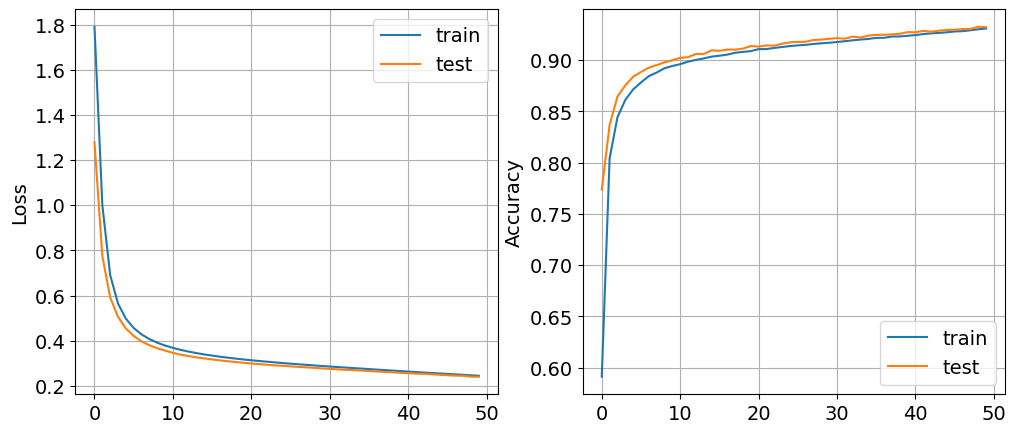

In [10]:
image0, label0 = train_dataset[0]
n_input=image0.shape[0]
n_hidden=128
n_output=10
model = Net(n_input, n_output, n_hidden).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

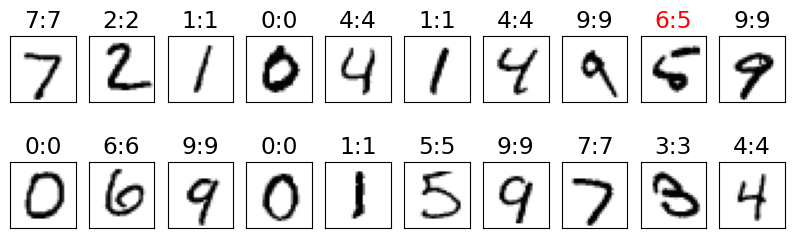

In [11]:
inputs, labels = list(test_loader)[0]
inputs = inputs.to(device)
outputs = model(inputs)
predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    input = inputs[i]
    label = labels[i]
    prediction = predictions[i]

    image = decode_to_image(input)
    plt.imshow(image, cmap='gray_r')

    if prediction == label:
        c = 'k'
    else:
        c = 'r'

    ax.set_title(f'{prediction}:{label}', c=c)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolution Network

Files already downloaded and verified
Files already downloaded and verified


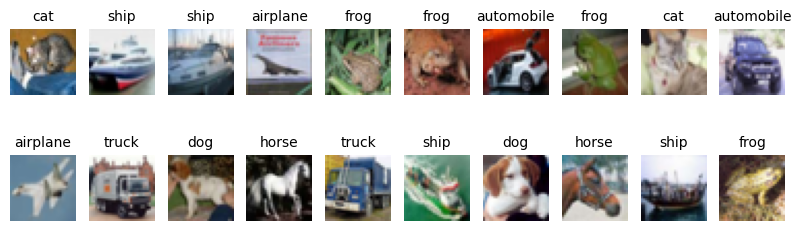

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,  0.5),
])

def decode_to_image(x):
    x = x * 0.5 + 0.5
    return transforms.ToPILImage()(x)

train_dataset = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

test_dataset = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

batch_size = 100
classes = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Visualize images.
images, labels = list(test_loader)[0]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    label_name = classes[labels[i]]

    image = decode_to_image(images[i])
    plt.imshow(image)
    ax.set_title(label_name, fontsize=10)
    ax.set_axis_off()
plt.show()

In [13]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            802,944
├─Linear: 1-7                            1,290
├─Sequential: 1-8                        10,144
│    └─Conv2d: 2-1                       (recursive)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (recursive)
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-9                        804,234
│    └─Linear: 2-6                       (recursive)
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       (recursive)
Total params: 1,628,756
Trainable params: 1,628,756
Non-trainable params: 0

Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.09095 acc: 0.25362 test_loss: 1.84168, test_acc: 0.35570


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73678 acc: 0.38720 test_loss: 1.61716, test_acc: 0.43100


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.57300 acc: 0.44206 test_loss: 1.49179, test_acc: 0.47100


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.44448 acc: 0.48598 test_loss: 1.48251, test_acc: 0.47460


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.34624 acc: 0.51904 test_loss: 1.33476, test_acc: 0.52010


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.28636 acc: 0.54160 test_loss: 1.28471, test_acc: 0.53910


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.22880 acc: 0.56594 test_loss: 1.26888, test_acc: 0.54340


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.18312 acc: 0.58142 test_loss: 1.19544, test_acc: 0.57430


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.14193 acc: 0.59724 test_loss: 1.17511, test_acc: 0.58460


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.10046 acc: 0.61330 test_loss: 1.20648, test_acc: 0.57320


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.06395 acc: 0.62542 test_loss: 1.13193, test_acc: 0.59950


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.02640 acc: 0.63920 test_loss: 1.12381, test_acc: 0.59870


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.98980 acc: 0.65482 test_loss: 1.07971, test_acc: 0.61790


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.95478 acc: 0.66480 test_loss: 1.07773, test_acc: 0.61660


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.92063 acc: 0.67642 test_loss: 1.05905, test_acc: 0.62850


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.88571 acc: 0.69034 test_loss: 1.04718, test_acc: 0.63440


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.85371 acc: 0.70176 test_loss: 1.02811, test_acc: 0.63900


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.82022 acc: 0.71286 test_loss: 1.02806, test_acc: 0.64390


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.78726 acc: 0.72626 test_loss: 1.14343, test_acc: 0.60200


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.75253 acc: 0.73782 test_loss: 1.00726, test_acc: 0.65310


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.71971 acc: 0.74874 test_loss: 1.04435, test_acc: 0.64770


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.69091 acc: 0.75940 test_loss: 1.02641, test_acc: 0.64680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.65062 acc: 0.77476 test_loss: 1.06011, test_acc: 0.64610


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.61865 acc: 0.78796 test_loss: 1.04809, test_acc: 0.65170


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.58455 acc: 0.79698 test_loss: 1.04443, test_acc: 0.65620


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.55287 acc: 0.81030 test_loss: 1.05085, test_acc: 0.66020


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.52173 acc: 0.81964 test_loss: 1.17605, test_acc: 0.62850


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48826 acc: 0.83268 test_loss: 1.15915, test_acc: 0.64060


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.45429 acc: 0.84608 test_loss: 1.25660, test_acc: 0.62680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.42436 acc: 0.85792 test_loss: 1.11942, test_acc: 0.64890


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.39444 acc: 0.86796 test_loss: 1.15072, test_acc: 0.65900


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.36207 acc: 0.87966 test_loss: 1.23484, test_acc: 0.64400


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.33129 acc: 0.89150 test_loss: 1.35624, test_acc: 0.63120


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.30651 acc: 0.89950 test_loss: 1.24154, test_acc: 0.65340


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.27592 acc: 0.91072 test_loss: 1.29096, test_acc: 0.65120


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.24791 acc: 0.92120 test_loss: 1.35338, test_acc: 0.64670


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.22852 acc: 0.92752 test_loss: 1.38229, test_acc: 0.64260


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.19874 acc: 0.93792 test_loss: 1.46317, test_acc: 0.64260


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.17407 acc: 0.94924 test_loss: 1.50481, test_acc: 0.64630


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.15632 acc: 0.95468 test_loss: 1.53746, test_acc: 0.65390


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.12523 acc: 0.96738 test_loss: 1.54504, test_acc: 0.65260


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.10718 acc: 0.97432 test_loss: 1.62750, test_acc: 0.65390


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.11189 acc: 0.97390 test_loss: 1.63861, test_acc: 0.64500


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.07433 acc: 0.98526 test_loss: 1.77946, test_acc: 0.65170


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.07394 acc: 0.98542 test_loss: 1.74713, test_acc: 0.65770


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.04700 acc: 0.99400 test_loss: 1.79039, test_acc: 0.65270


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03405 acc: 0.99740 test_loss: 1.84653, test_acc: 0.65490


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.02663 acc: 0.99854 test_loss: 1.89915, test_acc: 0.65170


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02298 acc: 0.99868 test_loss: 1.93480, test_acc: 0.65310


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.02004 acc: 0.99902 test_loss: 1.97601, test_acc: 0.65520


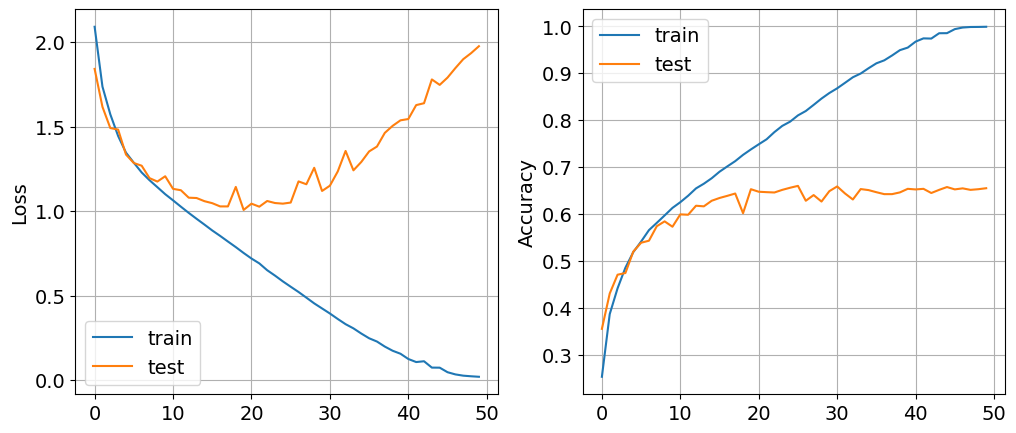

In [14]:
n_output = len(classes)
n_hidden = 128
model = CNN(n_output, n_hidden).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

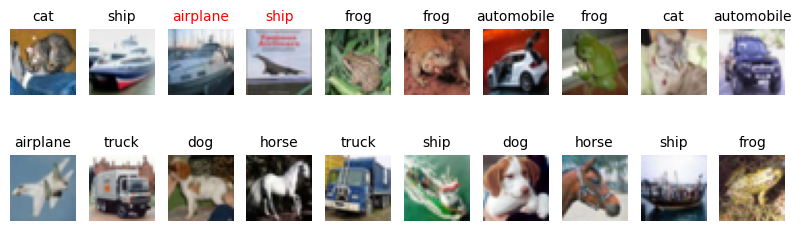

In [15]:
# Visualize images.
images, labels = list(test_loader)[0]
outputs = model(images.to(device))
predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    image = decode_to_image(images[i])
    label = labels[i]
    prediction = predictions[i]

    if label == prediction:
        c = 'k'
    else:
        c = 'r'

    plt.imshow(image)
    ax.set_title(classes[prediction], fontsize=10, c=c)
    ax.set_axis_off()
plt.show()

## CNN tuning
* Dropout
* Batch Normalization

In [16]:
class CNNv2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

Layer (type:depth-idx)                   Param #
CNNv2                                    --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            73,856
├─Conv2d: 1-6                            147,584
├─ReLU: 1-7                              --
├─Flatten: 1-8                           --
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           262,272
├─Linear: 1-11                           1,290
├─Dropout: 1-12                          --
├─Dropout: 1-13                          --
├─Dropout: 1-14                          --
├─BatchNorm2d: 1-15                      64
├─BatchNorm2d: 1-16                      64
├─BatchNorm2d: 1-17                      128
├─BatchNorm2d: 1-18                      128
├─BatchNorm2d: 1-19                      256
├─BatchNorm2d: 1-20                    

Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.79532 acc: 0.32750 test_loss: 1.56650, test_acc: 0.42570


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.43852 acc: 0.46920 test_loss: 1.41431, test_acc: 0.48700


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.27938 acc: 0.53642 test_loss: 1.21221, test_acc: 0.55620


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.17491 acc: 0.57548 test_loss: 1.06718, test_acc: 0.62010


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.09778 acc: 0.60508 test_loss: 1.03960, test_acc: 0.63230


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.03703 acc: 0.62882 test_loss: 0.98637, test_acc: 0.65110


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.98589 acc: 0.64738 test_loss: 1.02237, test_acc: 0.63160


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.94769 acc: 0.66276 test_loss: 0.95028, test_acc: 0.66050


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.90581 acc: 0.67788 test_loss: 0.87670, test_acc: 0.69180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.87416 acc: 0.68998 test_loss: 0.85160, test_acc: 0.69680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.84911 acc: 0.70242 test_loss: 0.75425, test_acc: 0.72960


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.81577 acc: 0.70976 test_loss: 0.75128, test_acc: 0.73060


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.78858 acc: 0.72138 test_loss: 0.75004, test_acc: 0.73190


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.76268 acc: 0.72998 test_loss: 0.76156, test_acc: 0.72930


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.74705 acc: 0.73580 test_loss: 0.67246, test_acc: 0.76230


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.73077 acc: 0.74158 test_loss: 0.71736, test_acc: 0.74990


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.71083 acc: 0.75062 test_loss: 0.75625, test_acc: 0.73180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.69511 acc: 0.75422 test_loss: 0.66616, test_acc: 0.76380


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.68176 acc: 0.76088 test_loss: 0.67068, test_acc: 0.76330


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.66682 acc: 0.76502 test_loss: 0.61680, test_acc: 0.78120


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.65700 acc: 0.76908 test_loss: 0.61919, test_acc: 0.77830


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.63995 acc: 0.77602 test_loss: 0.61940, test_acc: 0.78180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.63241 acc: 0.77806 test_loss: 0.59279, test_acc: 0.78990


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.62126 acc: 0.78162 test_loss: 0.64422, test_acc: 0.77170


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.60538 acc: 0.78760 test_loss: 0.56255, test_acc: 0.79940


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.59188 acc: 0.79062 test_loss: 0.59724, test_acc: 0.79230


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.58615 acc: 0.79624 test_loss: 0.58717, test_acc: 0.79300


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.57641 acc: 0.79718 test_loss: 0.55624, test_acc: 0.80230


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.56937 acc: 0.80076 test_loss: 0.55285, test_acc: 0.80410


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.55562 acc: 0.80706 test_loss: 0.53799, test_acc: 0.81030


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.54819 acc: 0.80720 test_loss: 0.53222, test_acc: 0.81310


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.54659 acc: 0.80932 test_loss: 0.52309, test_acc: 0.81810


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.53283 acc: 0.81320 test_loss: 0.53185, test_acc: 0.81600


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.52400 acc: 0.81680 test_loss: 0.58309, test_acc: 0.80180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.51919 acc: 0.81918 test_loss: 0.53355, test_acc: 0.81600


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.51078 acc: 0.82036 test_loss: 0.51772, test_acc: 0.82160


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.51056 acc: 0.82098 test_loss: 0.50821, test_acc: 0.82170


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.49779 acc: 0.82646 test_loss: 0.55447, test_acc: 0.80890


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.49086 acc: 0.82800 test_loss: 0.51164, test_acc: 0.82280


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.48869 acc: 0.82888 test_loss: 0.51073, test_acc: 0.82330


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.47756 acc: 0.83288 test_loss: 0.51683, test_acc: 0.82270


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.47128 acc: 0.83540 test_loss: 0.50079, test_acc: 0.82580


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.46758 acc: 0.83766 test_loss: 0.56296, test_acc: 0.80810


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.46460 acc: 0.83660 test_loss: 0.52871, test_acc: 0.81600


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.45818 acc: 0.83960 test_loss: 0.48703, test_acc: 0.83280


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.45039 acc: 0.84424 test_loss: 0.50093, test_acc: 0.83000


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.44166 acc: 0.84402 test_loss: 0.52896, test_acc: 0.82190


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.44233 acc: 0.84574 test_loss: 0.48367, test_acc: 0.83680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43844 acc: 0.84582 test_loss: 0.49540, test_acc: 0.82870


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43199 acc: 0.84782 test_loss: 0.48378, test_acc: 0.83690


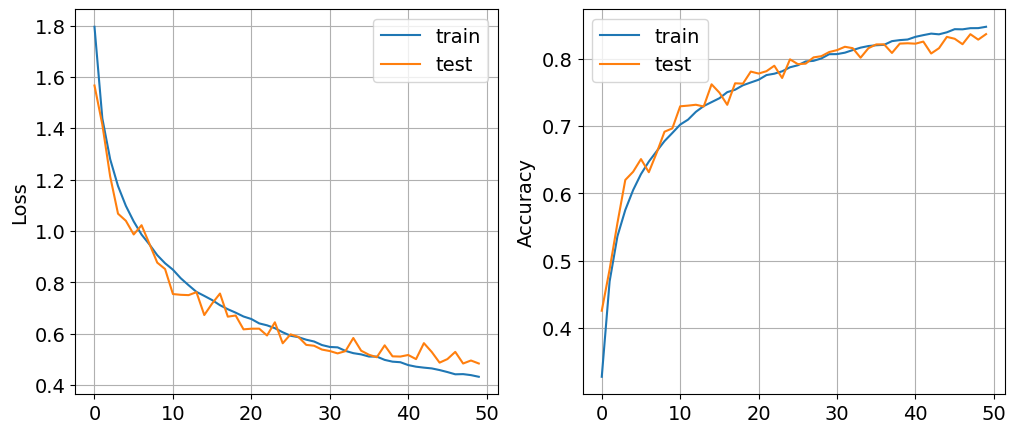

In [17]:
n_output = len(classes)
model = CNNv2(n_output).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

In [18]:
from google.colab import runtime
runtime.unassign()